In [1]:
# Install hdf5 library by interacting with the interpreter 
import sys
!{sys.executable} -m pip install hdf5storage
!{sys.executable} -m pip install tensorflow

# Import Libraries 
import hdf5storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from keras.models import Model

import keras
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
import tensorflow as tf
import scipy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.stats import ttest_rel
from scipy.stats import ttest_1samp
from math import sqrt

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier


2023-05-22 13:21:07.678983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Read and clean data

In [2]:
LOB_input = hdf5storage.loadmat('S092215-v50-AMZN_OCT2_states.mat')
LOB_Amazon = pd.DataFrame.from_dict(LOB_input['LOB'])

# Add Column Titles
LOB_Amazon.columns = [
                      "Time", "Mid_Price", "Spread", 
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10", # Level 10
                     ]
LOB_Amazon.head()

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
0,1442894410000,0,0,0,0,5427400,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1442894410000,5452100,49400,5476800,100,5427400,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1442894410073,5451900,49000,5476400,100,5427400,100,5476800,100,0,...,0,0,0,0,0,0,0,0,0,0
3,1442894410073,5452000,48800,5476400,100,5427600,100,5476800,100,5427400,...,0,0,0,0,0,0,0,0,0,0
4,1442894410073,5452000,48800,5476400,100,5427600,100,5476800,100,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Count number of rows where any of the specified columns is equal to 0
count = ((LOB_Amazon["Mid_Price"] == 0) |
         (LOB_Amazon["AskPrice1"] == 0) |
         (LOB_Amazon["AskVolume1"] == 0) |
         (LOB_Amazon["BidPrice1"] == 0) |
         (LOB_Amazon["BidVolume1"] == 0)).sum()

print("Number of rows where any of the specified columns is equal to 0:", count)


Number of rows where any of the specified columns is equal to 0: 2932


In [4]:
# Convert epoch time to readable format
import datetime
    
# Version 1.0
new_time_column = []
for item in LOB_Amazon["Time"]:
    current_row = datetime.datetime.fromtimestamp(item/1000.0) #1000.0 since 1 sec = 1000 mls
    new_time_column.append(current_row)

# Version 2.0
readable_time = []
for i in range(0,len(new_time_column)):
    current_time = new_time_column[i].strftime("%H:%M:%f")
    readable_time.append(current_time)

# Replace Unix time with the Readable Time Format (=Version 2.0)
LOB_Amazon['Time'] = readable_time 

# Remove rows where specified columns are equal to 0
LOB_Amazon = LOB_Amazon[(LOB_Amazon["Mid_Price"] != 0) &
                        (LOB_Amazon["AskPrice1"] != 0) &
                        (LOB_Amazon["AskVolume1"] != 0) &
                        (LOB_Amazon["BidPrice1"] != 0) &
                        (LOB_Amazon["BidVolume1"] != 0)]

In [5]:
LOB_Amazon.head(10)

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
1,05:00:000000,5452100,49400,5476800,100,5427400,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,05:00:073000,5451900,49000,5476400,100,5427400,100,5476800,100,0,...,0,0,0,0,0,0,0,0,0,0
3,05:00:073000,5452000,48800,5476400,100,5427600,100,5476800,100,5427400,...,0,0,0,0,0,0,0,0,0,0
4,05:00:073000,5452000,48800,5476400,100,5427600,100,5476800,100,0,...,0,0,0,0,0,0,0,0,0,0
5,05:00:073000,5452000,48800,5476400,100,5427600,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,05:00:073000,5452000,48800,5476400,100,5427600,100,5484000,100,0,...,0,0,0,0,0,0,0,0,0,0
7,05:00:146000,5451900,48600,5476200,100,5427600,100,5476400,100,0,...,0,0,0,0,0,0,0,0,0,0
8,05:00:146000,5451900,48600,5476200,100,5427600,100,5484000,100,0,...,0,0,0,0,0,0,0,0,0,0
9,05:00:395000,5455800,56400,5484000,100,5427600,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,05:00:395000,5455800,56400,5484000,100,5427600,100,5484200,100,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
LOB_Amazon.shape

(559718, 43)

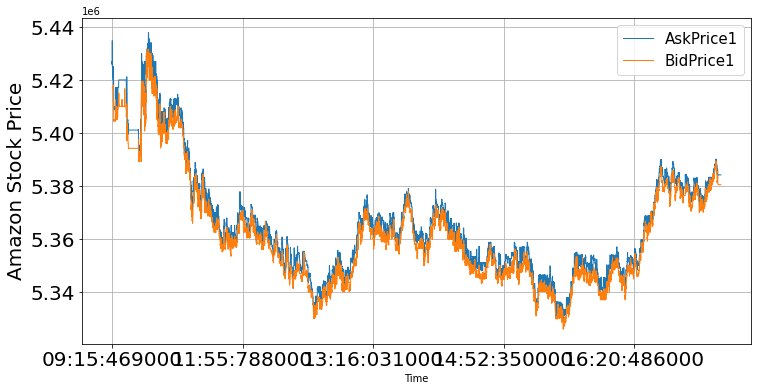

In [7]:
#Plot Best Ask and Bid Prices
import matplotlib.pyplot as plt

LOB_Amazon_Sample = LOB_Amazon.iloc[86000:552500,] # Time-framing

LOB_Amazon_Sample.plot(x="Time", y=["AskPrice1", "BidPrice1"],
                       figsize=(12, 6), linewidth=1.0, fontsize=20,
                       grid=True)

plt.legend(loc=1, prop={'size': 15})
plt.rcParams.update({'font.size': 10})
plt.ylabel('Amazon Stock Price',fontsize=20);

# 2. Prepare train and test sets

In [5]:
# Set the proportion of data to allocate for the test set
test_size = 0.2  # 20% for testing

# Calculate the index to split the data
split_index = int(len(LOB_Amazon) * (1 - test_size))

# Split the data into training and test sets
LOB_Amazon_train = LOB_Amazon.iloc[:split_index].copy()
LOB_Amazon_test = LOB_Amazon.iloc[split_index:].copy()

# Print the sizes of the train and test sets
print("Train set size:", len(LOB_Amazon_train))
print("Test set size:", len(LOB_Amazon_test))

Train set size: 447774
Test set size: 111944


# 3. Feature engineering

In [6]:
# Future midquote: dependant variable for regression tasks
Mid_Price_Future = LOB_Amazon_train['Mid_Price'].shift(-1)
LOB_Amazon_train.insert(1, 'Mid_Price_Future', Mid_Price_Future)

# Create a new column 'Price_Movement' for classification tasks
Price_Movement = np.where(LOB_Amazon_train['Mid_Price_Future'] >= LOB_Amazon_train['Mid_Price'], 1, 0)
LOB_Amazon_train.insert(2, 'Price_Movement', Price_Movement)

# Price velocity or average price change over the last n events
n = 5
LOB_Amazon_train['Price_Velocity'] = (LOB_Amazon_train['Mid_Price'] - LOB_Amazon_train['Mid_Price'].shift(n)) / n

# Order Imbalance
LOB_Amazon_train['Order_Imbalance'] = LOB_Amazon_train['BidVolume1'] - LOB_Amazon_train['AskVolume1']

# Lagged Features
LOB_Amazon_train['Ask_lag_1'] = LOB_Amazon_train['AskPrice1'].shift(1)
LOB_Amazon_train['Bid_lag_1'] = LOB_Amazon_train['BidPrice1'].shift(1)

# Lagged Return
LOB_Amazon_train['Lagged_Return'] = LOB_Amazon_train['Mid_Price'].pct_change()

# Short-term mean and volatility
LOB_Amazon_train['Rolling_Mean_5'] = LOB_Amazon_train['Mid_Price'].rolling(window=5).mean()
LOB_Amazon_train['Volatility_5'] = LOB_Amazon_train['Mid_Price'].rolling(window=5).std()

# Medium-term mean and volatility
LOB_Amazon_train['Rolling_Mean_50'] = LOB_Amazon_train['Mid_Price'].rolling(window=50).mean()
LOB_Amazon_train['Volatility_50'] = LOB_Amazon_train['Mid_Price'].rolling(window=50).std()

# Long-term mean and volatility
LOB_Amazon_train['Rolling_Mean_100'] = LOB_Amazon_train['Mid_Price'].rolling(window=100).mean()
LOB_Amazon_train['Volatility_100'] = LOB_Amazon_train['Mid_Price'].rolling(window=100).std()

# Average bid-ask spread
bid_cols = [f'BidPrice{i+1}' for i in range(10)]
ask_cols = [f'AskPrice{i+1}' for i in range(10)]
LOB_Amazon_train['Avg_Bid_Ask_Spread'] = LOB_Amazon_train[ask_cols].mean(axis=1) - LOB_Amazon_train[bid_cols].mean(axis=1)

# Cumulative Bid/Ask Volume
bid_sum = LOB_Amazon_train[bid_cols].sum(axis=1)
ask_sum = LOB_Amazon_train[ask_cols].sum(axis=1)
LOB_Amazon_train['Cumulative_Bid_Ask_Volume_Diff'] = bid_sum - ask_sum

# Drop NaN
LOB_Amazon_train = LOB_Amazon_train.dropna()


In [9]:
# Print all column names and LOB_Amazon_train shape
print(LOB_Amazon_train.columns)
print(LOB_Amazon_train.shape)


Index(['Time', 'Mid_Price_Future', 'Price_Movement', 'Mid_Price', 'Spread',
       'AskPrice1', 'AskVolume1', 'BidPrice1', 'BidVolume1', 'AskPrice2',
       'AskVolume2', 'BidPrice2', 'BidVolume2', 'AskPrice3', 'AskVolume3',
       'BidPrice3', 'BidVolume3', 'AskPrice4', 'AskVolume4', 'BidPrice4',
       'BidVolume4', 'AskPrice5', 'AskVolume5', 'BidPrice5', 'BidVolume5',
       'AskPrice6', 'AskVolume6', 'BidPrice6', 'BidVolume6', 'AskPrice7',
       'AskVolume7', 'BidPrice7', 'BidVolume7', 'AskPrice8', 'AskVolume8',
       'BidPrice8', 'BidVolume8', 'AskPrice9', 'AskVolume9', 'BidPrice9',
       'BidVolume9', 'AskPrice10', 'AskVolume10', 'BidPrice10', 'BidVolume10',
       'Price_Velocity', 'Order_Imbalance', 'Ask_lag_1', 'Bid_lag_1',
       'Lagged_Return', 'Rolling_Mean_5', 'Volatility_5', 'Rolling_Mean_50',
       'Volatility_50', 'Rolling_Mean_100', 'Volatility_100',
       'Avg_Bid_Ask_Spread', 'Cumulative_Bid_Ask_Volume_Diff'],
      dtype='object')
(447674, 58)


# 4. Feature Selection

In [7]:
# Separate the features and dependent variables 
X = LOB_Amazon_train.iloc[:, 3:].reset_index(drop=True)
y = LOB_Amazon_train['Mid_Price_Future'].reset_index(drop=True)

X.shape

(447674, 55)

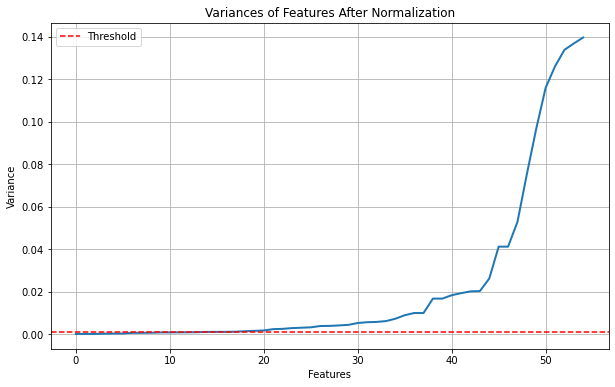

In [8]:
# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Calculate the variance of each feature
variances = np.var(X, axis=0)

# Sort the variances
sorted_variances = np.sort(variances)

# Plot the variances
plt.figure(figsize=(10, 6))
plt.plot(sorted_variances, linewidth=2)  
plt.axhline(y=0.001, color='r', linestyle='--', label='Threshold')  
plt.title('Variances of Features After Normalization')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.grid(True)  
plt.legend()  
plt.show()

In [9]:
# Apply variance threshold
var_threshold = VarianceThreshold(threshold=0.001)
X = var_threshold.fit_transform(X)

# Get the selected feature indices
selected_feature_indices = var_threshold.get_support(indices=True)

# Get the selected feature names
selected_feature_names = LOB_Amazon_train.columns[selected_feature_indices]

#  Display the selected feature names
print(selected_feature_names)
print(selected_feature_names.shape)


Index(['Time', 'Mid_Price_Future', 'Price_Movement', 'Mid_Price', 'Spread',
       'AskVolume1', 'BidPrice1', 'BidVolume1', 'AskVolume2', 'BidPrice2',
       'BidVolume2', 'AskPrice3', 'AskVolume3', 'BidPrice3', 'BidVolume3',
       'AskVolume4', 'BidPrice4', 'BidVolume4', 'AskVolume5', 'BidVolume5',
       'BidPrice6', 'BidVolume6', 'AskPrice7', 'BidPrice7', 'BidVolume7',
       'BidPrice8', 'BidVolume8', 'BidPrice9', 'BidVolume9', 'BidVolume10',
       'Price_Velocity', 'Ask_lag_1', 'Bid_lag_1', 'Lagged_Return',
       'Rolling_Mean_5', 'Volatility_5', 'Rolling_Mean_50', 'Volatility_50',
       'Rolling_Mean_100'],
      dtype='object')
(39,)


# 5. Model Selection (Regression)

In [15]:
# Initialize a dictionary to store the results
results = {}

1. SGDRegressor

In [16]:
# Initialize model
model = SGDRegressor()
model_name = 'SGDRegressor'

# Define the number of splits
n_splits = 5

# Initialize the time series cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits)

# Apply cross-validation
scores = cross_validate(model, X, y, cv=tscv, scoring=('neg_mean_squared_error', 'neg_root_mean_squared_error'), return_train_score=True)

# Save the results
results[model_name] = scores

# Access the scores for the model by using its name
sgd_scores = results['SGDRegressor']

# Print MSE and RMSE for training and test sets for each split
for i in range(n_splits):
    print(f"Fold {i+1}:")
    print(f" Training: MSE = {-sgd_scores['train_neg_mean_squared_error'][i]}, RMSE = {-sgd_scores['train_neg_root_mean_squared_error'][i]}")
    print(f" Test: MSE = {-sgd_scores['test_neg_mean_squared_error'][i]}, RMSE = {-sgd_scores['test_neg_root_mean_squared_error'][i]}")

Fold 1:
 Training: MSE = 168162413.5701011, RMSE = 12967.745122807632
 Test: MSE = 382206200.96560186, RMSE = 19550.09465362257
Fold 2:
 Training: MSE = 82431149.8062213, RMSE = 9079.160192783324
 Test: MSE = 3373482.726413716, RMSE = 1836.7043111001062
Fold 3:
 Training: MSE = 54769522.02476511, RMSE = 7400.643352085352
 Test: MSE = 127025.84766821658, RMSE = 356.40685693209747
Fold 4:
 Training: MSE = 40970448.51159276, RMSE = 6400.816237917846
 Test: MSE = 38266.180206107, RMSE = 195.61743328780028
Fold 5:
 Training: MSE = 33030785.442811783, RMSE = 5747.241550762573
 Test: MSE = 48840.76564816196, RMSE = 220.99946979158562


2. Random Forest

In [105]:
# Initialize model
model = RandomForestRegressor()
model_name = 'RandomForestRegressor'

# Define the number of splits
n_splits = 5

# Initialize the time series cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits)

# Apply cross-validation
scores = cross_validate(model, X, y, cv=tscv, scoring=('neg_mean_squared_error', 'neg_root_mean_squared_error'), return_train_score=True)

# Save the results
results[model_name] = scores

# Access the scores for the model by using its name
rf_scores = results['RandomForestRegressor']

# Print MSE and RMSE for training and test sets for each split
for i in range(n_splits):
    print(f"Fold {i+1}:")
    print(f" Training: MSE = {-rf_scores['train_neg_mean_squared_error'][i]}, RMSE = {-rf_scores['train_neg_root_mean_squared_error'][i]}")
    print(f" Test: MSE = {-rf_scores['test_neg_mean_squared_error'][i]}, RMSE = {-rf_scores['test_neg_root_mean_squared_error'][i]}")

Fold 1:
 Training: MSE = 19889787.520468682, RMSE = 4459.796802598598
 Test: MSE = 94736085.82903169, RMSE = 9733.246417769957
Fold 2:
 Training: MSE = 9939386.000803879, RMSE = 3152.67917822348
 Test: MSE = 55067365.92275685, RMSE = 7420.738906790674
Fold 3:
 Training: MSE = 6624285.082176369, RMSE = 2573.768653584927
 Test: MSE = 7739173.329039394, RMSE = 2781.936974311135
Fold 4:
 Training: MSE = 4967067.005738982, RMSE = 2228.691770016433
 Test: MSE = 41725.22367242582, RMSE = 204.26752965761793
Fold 5:
 Training: MSE = 3973795.89395175, RMSE = 1993.4382092133555
 Test: MSE = 118978.32349020384, RMSE = 344.93234625097693


3. Adaboost

In [106]:
# Initialize model
model = AdaBoostRegressor()
model_name = 'AdaBoostRegressor'

# Define the number of splits
n_splits = 5

# Initialize the time series cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits)

# Apply cross-validation
scores = cross_validate(model, X, y, cv=tscv, scoring=('neg_mean_squared_error', 'neg_root_mean_squared_error'), return_train_score=True)

# Save the results
results[model_name] = scores

# Access the scores for the model by using its name
ab_scores = results['AdaBoostRegressor']

# Print MSE and RMSE for training and test sets for each split
for i in range(n_splits):
    print(f"Fold {i+1}:")
    print(f" Training: MSE = {-ab_scores['train_neg_mean_squared_error'][i]}, RMSE = {-ab_scores['train_neg_root_mean_squared_error'][i]}")
    print(f" Test: MSE = {-ab_scores['test_neg_mean_squared_error'][i]}, RMSE = {-ab_scores['test_neg_root_mean_squared_error'][i]}")

Fold 1:
 Training: MSE = 307980219.6413801, RMSE = 17549.365220468233
 Test: MSE = 123928049.27093278, RMSE = 11132.297573768534
Fold 2:
 Training: MSE = 204022309.22872156, RMSE = 14283.637814951819
 Test: MSE = 1444921285.7810025, RMSE = 38012.12024842869
Fold 3:
 Training: MSE = 111632184.19084649, RMSE = 10565.613289859064
 Test: MSE = 192125409.2646761, RMSE = 13860.931038883215
Fold 4:
 Training: MSE = 105166918.76295088, RMSE = 10255.09233322406
 Test: MSE = 25430272.804703597, RMSE = 5042.843722018718
Fold 5:
 Training: MSE = 77121121.27678166, RMSE = 8781.863200755388
 Test: MSE = 55558815.77652572, RMSE = 7453.778624062142


In [119]:
import pandas as pd

# Create a dictionary with your data
data = {'Fold': [1, 2, 3, 4, 5],
        'Training_MSE': [307980219.6413801, 204022309.22872156, 111632184.19084649, 105166918.76295088, 77121121.27678166],
        'Training_RMSE': [17549.365220468233, 14283.637814951819, 10565.613289859064, 10255.09233322406, 8781.863200755388],
        'Test_MSE': [123928049.27093278, 1444921285.7810025, 192125409.2646761, 25430272.804703597, 55558815.77652572],
        'Test_RMSE': [11132.297573768534, 38012.12024842869, 13860.931038883215, 5042.843722018718, 7453.778624062142]}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Write the DataFrame to a CSV file
df.to_csv('third_model_scores.csv', index=False)

4. CNN

In [107]:
# Define the number of splits and model's name
model_name = 'CNN'
n_splits = 5

# Initialize the time series cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits)

# For each split/fold
for i, (train, test) in enumerate(tscv.split(X)):
    # print(f"Running fold {i+1}/{n_splits}")

    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
  
    # Regressors
    
    # Prepare CNN data - 3D Inputs of the format [samples, lookback period, features]
    look_back = 10

    # Train Set 
    X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
    Y_train_to_Numpy = pd.DataFrame(y_train).to_numpy()

    x_train_append_matrix = []
    y_train_append_matrix = []

    for j in range(len(X_train)-look_back):         
        feat_current_train = X_train_to_Numpy[j:j+look_back, :]
        label_current_train = Y_train_to_Numpy[j+look_back]
        x_train_append_matrix.append(feat_current_train)
        y_train_append_matrix.append(label_current_train)
    
    X_train_numpy = np.array(x_train_append_matrix)
    y_train_numpy = np.array(y_train_append_matrix)

    # Test Set 
    X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
    Y_test_to_Numpy = pd.DataFrame(y_test).to_numpy()

    look_back = 10
    x_test_append_matrix = []
    y_test_append_matrix = []

    for j in range(len(X_test)-look_back):          
        feat_current_test = X_test_to_Numpy[j:j+look_back, :]
        label_current_test = Y_test_to_Numpy[j+look_back]
        x_test_append_matrix.append(feat_current_test)
        y_test_append_matrix.append(label_current_test)
    
    X_test_numpy = np.array(x_test_append_matrix)
    y_test_numpy = np.array(y_test_append_matrix)

    # define the input shape
    input_shape = (look_back, X_train_numpy.shape[2])
    
    # define the model architecture
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling1D(2, padding='same')(x)
    
    x = Conv1D(16, 3, activation='relu', padding='same')(encoded)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(1, 3, activation='linear', padding='same')(x)
    
    # create the model
    model = keras.Model(inputs, decoded)
    
    # compile the model
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_numpy, y_train_numpy, epochs=5, batch_size=32)

    # Evaluate the model
    train_mse = model.evaluate(X_train_numpy, y_train_numpy, verbose=0)
    test_mse = model.evaluate(X_test_numpy, y_test_numpy, verbose=0)

    # Compute RMSE
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    # Store the negative scores
    if i == 0:
        results[model_name] = {'train_neg_mean_squared_error': [-train_mse],
                                'train_neg_root_mean_squared_error': [-train_rmse],
                                'test_neg_mean_squared_error': [-test_mse], 
                                'test_neg_root_mean_squared_error': [-test_rmse]}
    else:
        results[model_name]['train_neg_mean_squared_error'].append(-train_mse)
        results[model_name]['train_neg_root_mean_squared_error'].append(-train_rmse)
        results[model_name]['test_neg_mean_squared_error'].append(-test_mse)
        results[model_name]['test_neg_root_mean_squared_error'].append(-test_rmse)


    print(f"Fold {i+1} done")

# Print the negative MSE and RMSE for each fold
for i in range(n_splits):
    train_neg_mse = results[model_name]['train_neg_mean_squared_error'][i]
    train_neg_rmse = results[model_name]['train_neg_root_mean_squared_error'][i]
    test_neg_mse = results[model_name]['test_neg_mean_squared_error'][i]
    test_neg_rmse = results[model_name]['test_neg_root_mean_squared_error'][i]
    print(f"Fold {i+1}:")
    print(f" Training: Neg MSE = {train_neg_mse}, Neg RMSE = {train_neg_rmse}")
    print(f" Test: Neg MSE = {test_neg_mse}, Neg RMSE = {test_neg_rmse}")

Epoch 1/5
2332/2332 [==============================] - 6s 2ms/step - loss: 4092048965632.0000
Epoch 2/5
2332/2332 [==============================] - 4s 2ms/step - loss: 104256110592.0000
Epoch 3/5
2332/2332 [==============================] - 4s 2ms/step - loss: 21025368064.0000
Epoch 4/5
2332/2332 [==============================] - 4s 2ms/step - loss: 10213720064.0000
Epoch 5/5
2332/2332 [==============================] - 4s 2ms/step - loss: 3016306176.0000
Fold 1 done
Epoch 1/5
4663/4663 [==============================] - 11s 2ms/step - loss: 2178097348608.0000
Epoch 2/5
4663/4663 [==============================] - 9s 2ms/step - loss: 18019477504.0000
Epoch 3/5
4663/4663 [==============================] - 10s 2ms/step - loss: 1687537792.0000
Epoch 4/5
4663/4663 [==============================] - 10s 2ms/step - loss: 279952000.0000
Epoch 5/5
4663/4663 [==============================] - 10s 2ms/step - loss: 186543536.0000
Fold 2 done
Epoch 1/5
6995/6995 [==============================] 

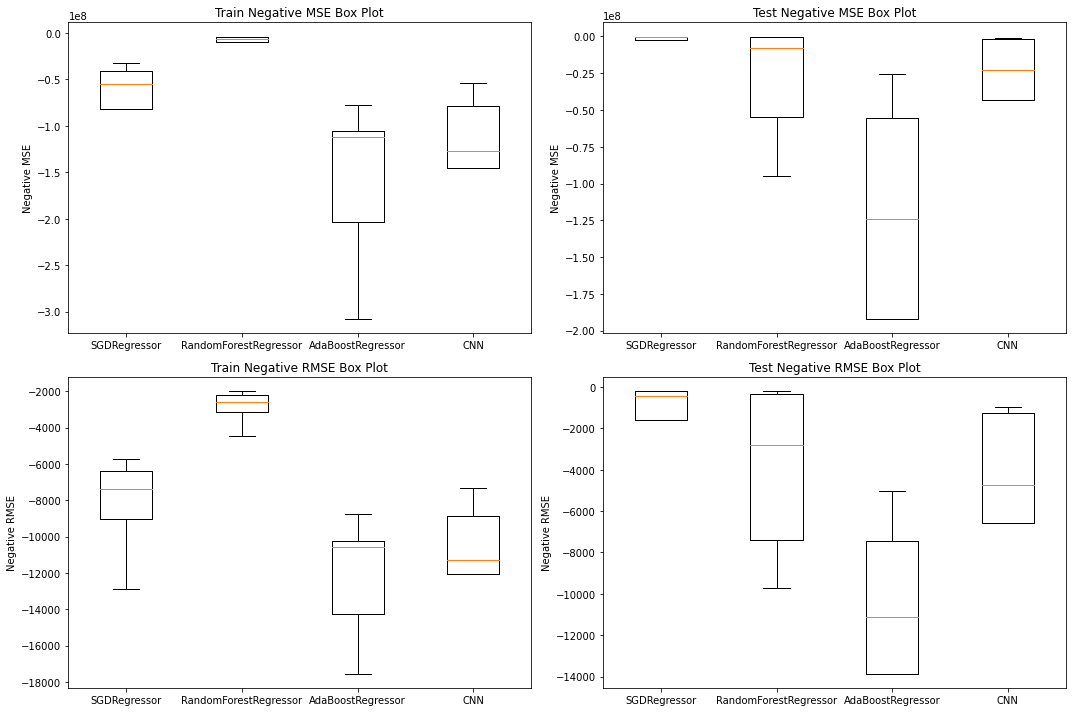

In [110]:
import matplotlib.pyplot as plt

models = ['SGDRegressor', 'RandomForestRegressor', 'AdaBoostRegressor', 'CNN']

# get the test and train scores from each fold for all models
test_neg_mse_scores = [results[model]['test_neg_mean_squared_error'] for model in models]
train_neg_mse_scores = [results[model]['train_neg_mean_squared_error'] for model in models]

test_neg_rmse_scores = [results[model]['test_neg_root_mean_squared_error'] for model in models]
train_neg_rmse_scores = [results[model]['train_neg_root_mean_squared_error'] for model in models]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Plot the train MSE scores for each model
axes[0].boxplot(train_neg_mse_scores,showfliers=False)
axes[0].set_xticklabels(models)
axes[0].set_ylabel('Negative MSE')
axes[0].set_title('Train Negative MSE Box Plot')

# Plot the test MSE scores for each model
axes[1].boxplot(test_neg_mse_scores,showfliers=False)
axes[1].set_xticklabels(models)
axes[1].set_ylabel('Negative MSE')
axes[1].set_title('Test Negative MSE Box Plot')

# Plot the train RMSE scores for each model
axes[2].boxplot(train_neg_rmse_scores,showfliers=False)
axes[2].set_xticklabels(models)
axes[2].set_ylabel('Negative RMSE')
axes[2].set_title('Train Negative RMSE Box Plot')

# Plot the test RMSE scores for each model
axes[3].boxplot(test_neg_rmse_scores,showfliers=False)
axes[3].set_xticklabels(models)
axes[3].set_ylabel('Negative RMSE')
axes[3].set_title('Test Negative RMSE Box Plot')

plt.tight_layout()
plt.show()


# 5. Model Selection (Classification)

In [14]:
# Separate the features and dependent variables 
X = LOB_Amazon_train.iloc[:, 3:].reset_index(drop=True)
y = LOB_Amazon_train['Price_Movement'].reset_index(drop=True)

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X.shape

(447674, 55)

Number of principal components: 11


/Users/Nico/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nico/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nico/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nico/opt/anaconda3/lib/python3.9/site-packages/sklearn


Model: Logistic Regression
Mean Accuracy: 0.9409800032166407
Mean F1-Score (weighted): 0.9193187451888607
Mean Precision (weighted): 0.8987766249280009
Mean Recall (weighted): 0.9409800032166407
Confusion Matrix: 
 [[5.90000e+01 1.93950e+04]
 [2.62300e+03 3.50983e+05]]


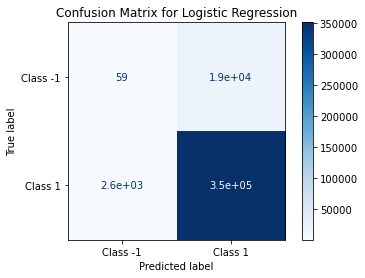

/Users/Nico/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Apply PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

# Get number of principal components
n_components = pca.n_components_
print(f'Number of principal components: {n_components}')

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the models
lr = LogisticRegression(max_iter=1000)
svm = SVC()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()

models = [lr, svm, rf, ada]
model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'AdaBoost']

for i, model in enumerate(models):
    accuracy_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    confusion_matrix_result = np.zeros((2,2))  # initialize a 2x2 matrix with zeros
    
    for train_index, test_index in tscv.split(X_reduced):
        X_train, X_test = X_reduced[train_index], X_reduced[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        confusion_matrix_result += confusion_matrix(y_test, y_pred)
        accuracy_scores.append(metrics.accuracy_score(y_test, y_pred))
        f1_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        
    print(f'\nModel: {model_names[i]}')
    print(f'Mean Accuracy: {np.mean(accuracy_scores)}')
    print(f'Mean F1-Score (weighted): {np.mean(f1_scores)}')
    print(f'Mean Precision (weighted): {np.mean(precision_scores)}')
    print(f'Mean Recall (weighted): {np.mean(recall_scores)}')
    print("Confusion Matrix: \n", confusion_matrix_result)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result, display_labels=['Class -1', 'Class 1'])
    disp.plot(cmap='Blues', ax=None, xticks_rotation='horizontal')
    plt.title(f'Confusion Matrix for {model_names[i]}')
    plt.show()

# 6. Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Initialize model
model = SGDRegressor(tol=1e-2)

n_splits = 5

# Initialize the time series cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the parameter distributions 
param_dist = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(loc=0, scale=0.1), # uniform distribution from 0 to 0.1
    'l1_ratio': uniform(),  # uniform distribution from 0 to 1
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [1000, 5000, 10000]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(model, param_dist, n_iter=100, cv=tscv, scoring='neg_mean_squared_error',
                                    random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X, y)

# Get the best parameters
best_params = random_search.best_params_

# Print the best parameters
print(best_params)

